# Risk Measurement Tool

This tool calculates VaR for basic and derivative financial products

Day 0 = Friday, February 2, 2024.

Day 1 market values with Day 0 portfolio backtested against Day 0 VaR

NASDAQ Data from: https://www.nasdaq.com/market-activity/quotes/historical

In [ ]:
# VaR / SVaR & Capital Calculation
# Backtesting
# Stress Testing & Limit Monitoring
# Greeks

# Futures, Forwards, Options, Interest Rate Swaps
# Stocks, Bonds, Forex, Interest Rate, Commodities
# Excel, Power BI/Tableau. CALCULATE ALL THESE IN EXCEL VBA AS WELL

## Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sympy import symbols, diff
import pytest
import unittest

# Value at Risk (VaR)

SVaR is calculated in the same way as VaR, but instead of the past year's data, we use data from a year with worse market conditions such as 2008 or 1987. SVaR is used for Capital calculations along with VaR

## Basic Example: 1 AAPL stock

###### Stocks

Find stock price data for each day from the past year

Find each of the Portfolio's Profit and Loss (PnL) value for each of the days, totaling approximately 250 business days in a year.

VaR is the bottom 1st percentile of the PnL distribution

In [ ]:
# file path to csv data
csv_file_path = "/content/Apple_VaR.csv"

# Extract raw data and store it in a Pandas DataFrame
raw_data = pd.read_csv(csv_file_path)

# Convert market close values to floats. Only keep 'Date' and 'Close' columns
market_values = raw_data[['Date', 'Close/Last']].rename(columns={'Close/Last': 'Close'})
remove_dollar_sign = lambda x: float(x.replace('$', ''))
market_values['Close'] = market_values['Close'].apply(remove_dollar_sign)

raw_data.head(), market_values.tail()
market_values.tail()

,Date,Close
245,02/10/2023,151.01
246,02/09/2023,150.87
247,02/08/2023,151.92
248,02/07/2023,154.65
249,02/06/2023,151.73


###### Method 1: simply finding each rise and fall as the pnl distribution

In [ ]:
all_pnl_values = [] # Profit and Loss (PnL) array storing all PnL values

# for loop to calculate values in PnL distribution
for i in range (len(market_values) - 1):
  stock_price_change = market_values.loc[i]['Close'] - market_values.loc[i+1]['Close']
  all_pnl_values.append(stock_price_change)

print(f"Length of pnl distrubtion array: {len(all_pnl_values)}\n5 lowest pnl values: {all_pnl_values[:5]}")

pnl_1st_percentile = np.percentile(all_pnl_values, [1]) # Value at Risk
pnl_1st_percentile

Length of pnl distrubtion array: 249
5 lowest pnl values: [-1.0100000000000193, 2.460000000000008, -3.6399999999999864, -3.6899999999999977, -0.6899999999999977]


array([-6.0988])

###### Method 2: Alternative way, using Log Return, Return PnL

In [ ]:
all_pnl_values_2 = [] # Profit and Loss (PnL) array storing all PnL values

# for loop to calculate values in PnL distribution
for i in range(len(market_values) - 1):
  log_return = np.log(market_values.loc[i]['Close'] / market_values.loc[i+1]['Close'])
  return_pnl = market_values.loc[0]['Close'] * log_return
  all_pnl_values_2.append(return_pnl)

pnl_1st_percentile_2 = np.percentile(all_pnl_values, 1) # VaR
pnl_1st_percentile_2

-6.098799999999994

#### Graph Comparison chart between 2 methods for PnL distribution calculations

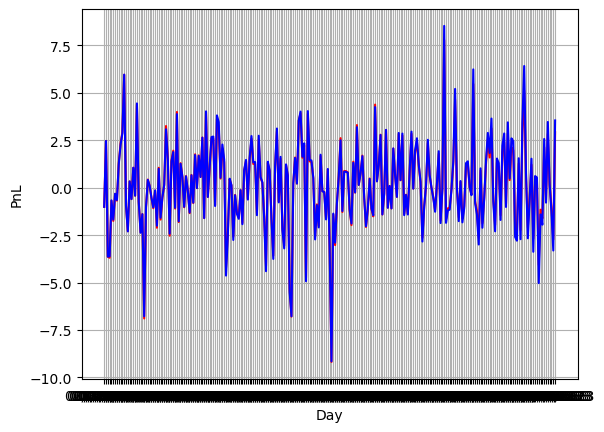

In [ ]:
x = list(market_values['Date'])[1:]
plt.plot(x, all_pnl_values, 'r',
        x, all_pnl_values_2, 'b')

plt.xlabel("Day")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

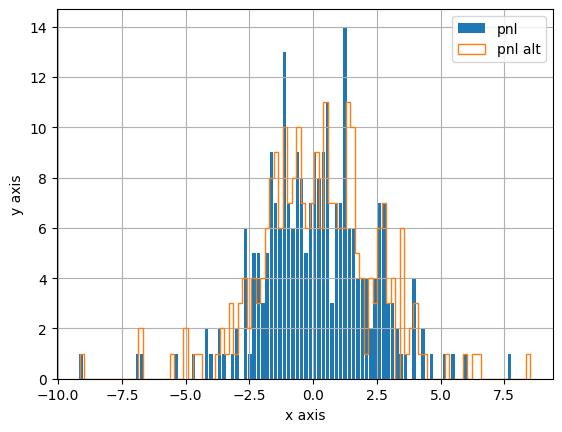

In [ ]:
# histograms:
plt.hist(all_pnl_values, rwidth=0.8, bins=100, label='pnl')
plt.hist(all_pnl_values_2, rwidth=0.8, bins=100, label='pnl alt', histtype='step')

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.legend()
plt.grid(True)
plt.show()

## Load Data From CSV

In [ ]:
# file directory to all csv files
csv_file_dir = []
for file in os.listdir('/content/'):
  if(file.endswith('.csv')):
    csv_file_dir.append(file)

print(csv_file_dir)

['Apple_VaR.csv', 'Starbucks_VaR.csv']


## Clean and Preprocess Data

e.g. 2 AAPL and 1 SBUX

FIX REQUIRED: find a way to count how many shares of each company they have

This program assumes you only add the csv data to the companies where you own shares

In [ ]:
market_data = dict() # all csv data of companies in portfolio

remove_dollar_sign = lambda x: float(x.replace('$', '')) # formatting fn

# get raw data, extract required cols, fix formatting of values
for i in csv_file_dir:
  market_data[i] = pd.read_csv(i)[['Date', 'Close/Last']].rename(columns={'Close/Last': 'Close'})
  market_data[i]['Close'] = market_data[i]['Close'].apply(remove_dollar_sign)


# MANUALLY ENTERED: number of stocks for each company in portfolio
num_shares = {
    list(market_data.keys())[0]: 2,
    list(market_data.keys())[1]: 1
}

## Calculate Values Profit and Loss (PnL) Distribution

In [ ]:
# dic of arrays storing all Profit and Loss (PnL) values for each firm in portfolio
pnl_port = dict()
for j in market_data:
  pnl_port[j] = []

# calculate all values in PnL distribution
for j in market_data:
  for i in range(len(list(market_data.values())[0]) - 1):
    log_return = np.log(market_data[j].loc[i]['Close'] / market_data[j].loc[i+1]['Close'])
    return_pnl = market_data[j].loc[0]['Close'] * log_return
    pnl_port[j].append(return_pnl)

## Calculate VaR (1st Percentile of PnL Distribution)

In [ ]:
# find first percentile in pnl distribution for each company * shares owned
pnl_first_percentile = []
for j in market_data:
  pnl_first_percentile.append(np.percentile(pnl_port[j], 1) * num_shares[j])

var = sum(pnl_first_percentile) / sum(num_shares.values()) # Value at Risk

In [ ]:
# DISPLAY FIGURES
var, pnl_first_percentile
print(f"VaR: {var}")

VaR: -4.894463347564042


## Visualizations and Reporting

In [ ]:
# TEST CELL
list(pnl_port.values())[0] == pnl_port[list(pnl_port)[0]]

True

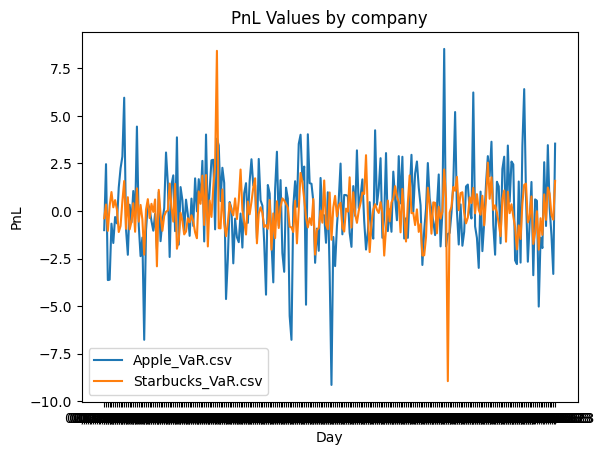

In [ ]:
x = list(market_data.values())[0]['Date'][1:]

for i in pnl_port:
  plt.plot(x, pnl_port[i], label=i)

plt.title("PnL Values by company")
plt.xlabel("Day")
plt.ylabel("PnL")
plt.legend()
plt.show()

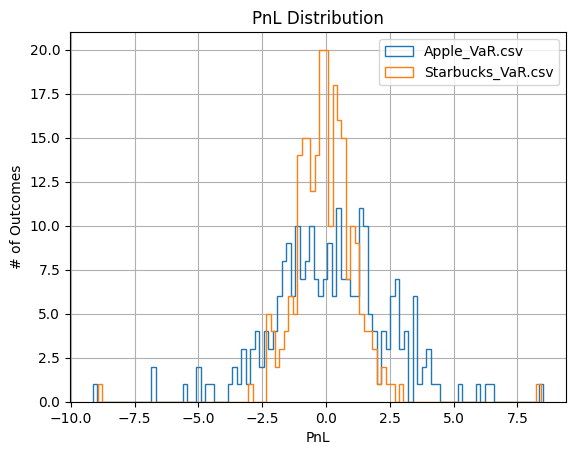

In [ ]:
# histograms:
for i in range(len(pnl_port)):
  plt.hist(list(pnl_port.values())[i], rwidth=0.8, bins=100, label=list(pnl_port.keys())[i], histtype='step')

plt.title("PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("# of Outcomes")
plt.legend()
plt.grid(True)
plt.show()

# Back Testing

In [ ]:
# Take present day's PnL and compare it to previous day's VaR
# Ensure Day 1's Portfolio PnL value (with Day 0's portfolio) > Day 0's VaR
# Else: "Exception"

# Forwards and Futures

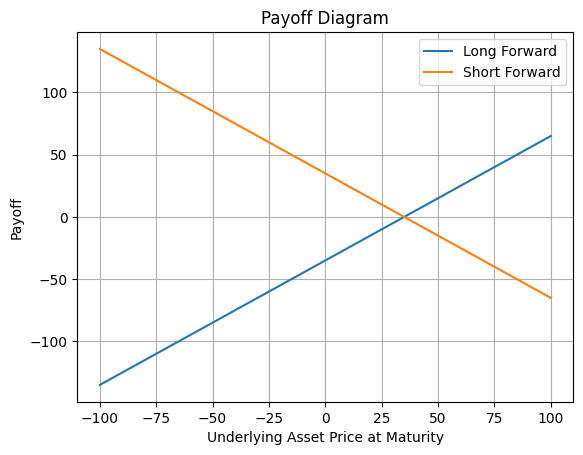

In [ ]:
# Forward / Future Payoff Diagram
forward_price = 35
maturity_date = 250/365

x = np.linspace(-100, 100, 199)

plt.plot(x, x-forward_price, label="Long Forward")
plt.plot(x, -x+forward_price, label="Short Forward")

plt.title("Payoff Diagram")
plt.xlabel("Underlying Asset Price at Maturity")
plt.ylabel("Payoff")
plt.legend()
plt.grid(True)
plt.show()

# Greeks and Black-Scholes

In [ ]:
# Options
# Strike Price, Expiry, Premiums, Interal Payoff
# Visualize Payoff Diagram

In [ ]:
# Arbitrary Example values to use for Option prices
r = 0.07 # interest rate
S = 20 # Underlying Price
K = 35 # strike price
T = 250/365 # time to expiry: 250 days / 365 days
sigma = 0.3 # annualized volatility as a percentage

p = 15 # premium

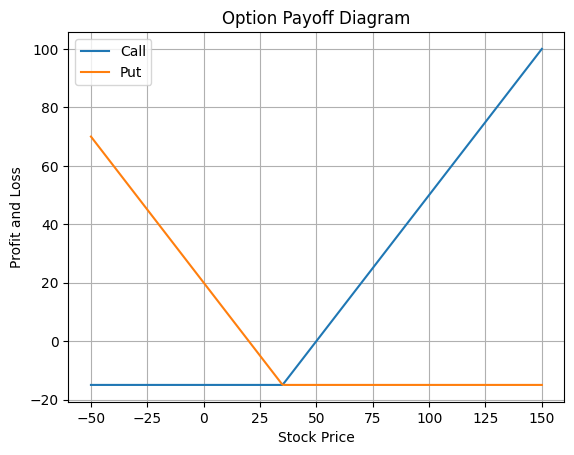

In [ ]:
# Plot Piecewise function representing option
x = np.linspace(-50, 150, 199)

def call_plot_f(x):
  if(x > K): return x-K-p
  else: return -p

def put_plot_f(x):
  if(x < K): return -x+K-p
  else: return -p

call_plot_y = []
put_plot_y = []
for i in range(len(x)):
  call_plot_y.append(call_plot_f(x[i]))
  put_plot_y.append(put_plot_f(x[i]))

# plt.subplot(1, 2, 1)
plt.plot(x, call_plot_y, label="Call")
# plt.subplot(1, 2, 2)
plt.plot(x, put_plot_y, label="Put")

# plt.plot(x, -p*np.ones(len(x)), label="Call Out-Of-The-Money")
# plt.plot(x, x-K-p, label="Call In-The-Money")
# plt.plot(x, -p*np.ones(len(x)), label="Put Out-Of-The-Money")
# plt.plot(x, -x+K-p, label="Put In-The-Money")

plt.title("Option Payoff Diagram")
plt.xlabel("Stock Price")
plt.ylabel("Profit and Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
d2 = d1 - (sigma * np.sqrt(T))

# Black-Scholes Model Equations
black_Scholes_call = (S * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
black_Scholes_put = (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1))

In [ ]:
# delta: 1st-order sensitivity to stock price
# delta_c = norm.cdf(d1, 0, 1) # default values are already loc=0, scale=1
delta_c = norm.cdf(d1)
delta_p = -norm.cdf(-d1)

# gamma: 2nd-order sensitivity to stock price
gamma_val = norm.pdf(d1) / (S*sigma*np.sqrt(T))

# vega: 1st-order sensitivity to implied volatility
vega_val = S * norm.pdf(d1) * np.sqrt(T)

# rho: 1st-order sensitivity to interest rate
rho_c = K * T * np.exp(-r*T) * norm.cdf(d2)
rho_p = -K * T * np.exp(-r*T) * norm.cdf(-d2)

# theta: 1st-order sensitivity to passage of time
theta_c = -( S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) ) - (r * K * np.exp(-r*T) * norm.cdf(d2))
theta_p = -( S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) ) + (r * K * np.exp(-r*T) * norm.cdf(-d2))

### Compare to Library to validate using py_vollib library

In [ ]:
!pip install py_vollib
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, rho, theta
from py_vollib.black_scholes import black_scholes

In [ ]:
def compare(calculated, answer):
  return round(calculated, 14) == round(answer, 14)

print(compare(delta_c, delta('c', S, K, T, r, sigma)), compare(delta_p, delta('p', S, K, T, r, sigma))) # delta
print(compare(gamma_val, gamma('c', S, K, T, r, sigma)), compare(gamma_val, gamma('p', S, K, T, r, sigma))) # gamma
print(compare(vega_val * 0.01, vega('c', S, K, T, r, sigma)), compare(vega_val * 0.01, vega('p', S, K, T, r, sigma))) # vega
print(compare(theta_c/365, theta('c', S, K, T, r, sigma)), compare(theta_p/365, theta('p', S, K, T, r, sigma))) # theta
print(compare(rho_c*0.01, rho('c', S, K, T, r, sigma)), compare(rho_p*0.01, rho('p', S, K, T, r, sigma))) # rho
print(compare(black_Scholes_call, black_scholes('c', S, K, T, r, sigma)), compare(black_Scholes_put, black_scholes('p', S, K, T, r, sigma))) # Black-Scholes

True True
True True
True True
True True
True True
True True


## Hedging Example

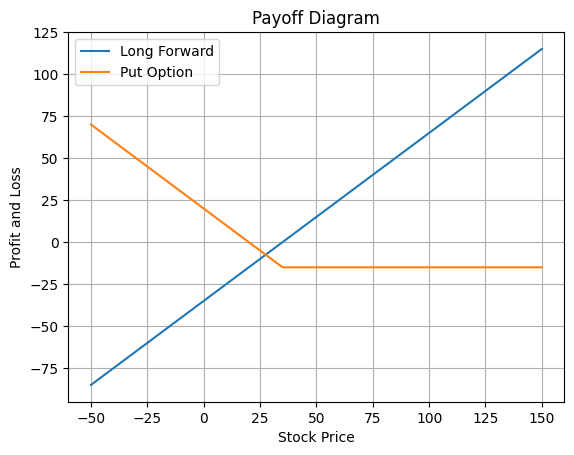

In [ ]:
# plt.plot(x, x-forward_price-p, label="Long Forward (-Option Premium)")
plt.plot(x, x-forward_price, label="Long Forward")
plt.plot(x, put_plot_y, label="Put Option")
plt.title("Payoff Diagram")
plt.xlabel("Stock Price")
plt.ylabel("Profit and Loss")
plt.legend()
plt.grid(True)
plt.show()

# Unit Testing

###### Intro

In [ ]:
# TEST CELL PLAYING WITH sympy
from sympy import symbols, diff

# strike = symbols('K') # variable name, and output variable name
x = symbols('DISPLAY_VARIABLE_NAME')
x = symbols('x')
f = x ** 2 + 3*x + 5
f_of_x = 2*x**3 + 5*x**2 - 3*x + 69
derivative = diff(f, x) # f_prime
print(f"Equation: {f}\nDerivative: {derivative}\n")
print(f"Equation: {f_of_x}\nDerivative: {diff(f_of_x, x)}")

Equation: x**2 + 3*x + 5
Derivative: 2*x + 3

Equation: 2*x**3 + 5*x**2 - 3*x + 69
Derivative: 6*x**2 + 10*x - 3


*   (Sanity, Validation, Stress) Test programmed Black-Scholes and Greeks equations for option pricing,

*   ensuring all values on visualization graphs are correct and not undefined,

*   no code breaking in VaR calculations,

*   Insertion of try-except statements for attempting something that can break code or for when receiving user input,

*   Back testing section must be finished still

*   Stress testing section not required: since it's just grabbing PnL value during stressed market conditions (hypothetical or based on past events i.e. COVID, natural disasters)

###### Manual Checks

In [ ]:
# Sanity check delta values
r, S, K, T, sigma = 0, 0, 1, 0, 0
r, S, K, T, sigma = 1, 0, 1, 1, 1

d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
d2 = d1 - (sigma * np.sqrt(T))
delta_c = norm.cdf(d1)

d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
d2 = d1 - (sigma * np.sqrt(T))
delta_p = -norm.cdf(-d1)

delta_c, delta_p

<ipython-input-26-36db3d0f7883>:5: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
<ipython-input-26-36db3d0f7883>:9: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))


(0.0, -1.0)

In [ ]:
def delta_call(r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = norm.cdf(d1)
  return delta
def delta_put(r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = -norm.cdf(-d1)
  return delta
delta_call(1, 0, 1, 1, 1) == 0, delta_put(1, 0, 1, 1, 1) == -1

<ipython-input-27-a01d6f3f57f2>:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
<ipython-input-27-a01d6f3f57f2>:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))


(True, True)

###### Pytest

In [ ]:
%%file test_sanity_delta.py

import numpy as np
from scipy.stats import norm
import pytest

def pytest_sessionstart(config): # hook
  print("Pytest session has commenced")
  print(f"config: {config}")

def pytest_sessionfinish(session, exitstatus): # hook
  print("Pytest session finished")
  print(f"session: {session}\nExit Status: {exitstatus}")

@pytest.fixture # fixture
def sanity_data():
  r, S, K, T, sigma = 1, 0, 1, 1, 1
  call_option_price, put_option_price = 0, -1
  return [r, S, K, T, sigma, call_option_price, put_option_price]

@pytest.mark.full_option_sanity # marker
def test_data_input_values(sanity_data):
  assert (1 and 0 in sanity_data), f"Wrong values, check values in {sanity_data}"
  assert sanity_data[0] == 1, f"Interest rate: expected 1, but got {sanity_data[0]}"
  assert sanity_data[1] == 0, f"Underlying Price: expected 0, but got {sanity_data[1]}"
  assert sanity_data[2] == 1, f"Strike Price: expected 1, but got {sanity_data[2]}"
  assert sanity_data[3] == 1, f"Time to Expiry: expected 1, but got {sanity_data[3]}"
  assert sanity_data[4] == 1, f"Annualized Volatility: expected 1, but got {sanity_data[4]}"
  assert sanity_data[5] == 0, f"Call Option Price: expected 0, but got {sanity_data[5]}"
  assert sanity_data[6] == -1, f"Put Option Price: expected -1, but got {sanity_data[6]}"


def delta_call(r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = norm.cdf(d1)
  return delta

def delta_put(r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = -norm.cdf(-d1)
  return delta

@pytest.mark.parametrize("r, S, K, T, sigma, expected_result", [(1, 0, 1, 1, 1, 0)])
def test_sanity_call(r, S, K, T, sigma, expected_result):
  assert delta_call(r, S, K, T, sigma) == expected_result, f'Uh oh'

@pytest.mark.parametrize("r, S, K, T, sigma, expected_result", [(1, 0, 1, 1, 1, -1)])
def test_sanity_put(r, S, K, T, sigma, expected_result):
  assert delta_put(r, S, K, T, sigma) == expected_result, f'Oh no'

@pytest.mark.parametrize("r, S, K, T, sigma, expected_call_price, expected_put_price", [(1, 0, 1, 1, 1, 0, -1)])
def test_validation(r, S, K, T, sigma, expected_call_price, expected_put_price):
  call_result, put_result = delta_call(r, S, K, T, sigma), delta_put(r, S, K, T, sigma)
  assert call_result == expected_call_price, f"Expected 0, but got {call_result}"
  assert put_result == expected_put_price, f"Expected -1, but got {put_result}"

Writing test_sanity_delta.py


In [ ]:
!python -m pytest test_sanity_delta.py

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.4.0
rootdir: /content
plugins: anyio-3.7.1
collected 4 items                                                                                  

test_sanity_delta.py ....                                                                    [100%]

========================================= warnings summary =========================================
test_sanity_delta.py:20
  /content/test_sanity_delta.py:20: PytestUnknownMarkWarning: Unknown pytest.mark.full_option_sanity - is this a typo?  You can register custom marks to avoid this warning - for details, see https://docs.pytest.org/en/stable/how-to/mark.html
    @pytest.mark.full_option_sanity # marker

test_sanity_delta.py::test_sanity_call[1-0-1-1-1-0]
test_sanity_delta.py::test_validation[1-0-1-1-1-0--1]
  /content/test_sanity_delta.py:33: RuntimeWarning: divide by zero encountered

###### Unittest

In [ ]:
%%file test_sanity_unittest_delta.py

import unittest
import numpy as np
from scipy.stats import norm

def delta_call(self, r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = norm.cdf(d1)
  return delta

def delta_put(self, r, S, K, T, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))
  delta = -norm.cdf(-d1)
  return delta

Writing test_sanity_unittest_delta.py


In [ ]:
%%file test_calc_unittest.py

import unittest

class TestExample(unittest.TestCase):

  def test_sanity_call(self):
    assert delta_call(1, 0, 1, 1, 1) == 0, f'Uh oh'

  def test_sanity_put(self):
    assert delta_put(1, 0, 1, 1, 1) == -1, f'Oh no'

  def test_validation(self):
    call_result, put_result = delta_call(1, 0, 1, 1, 1), delta_put(1, 0, 1, 1, 1)
    assert call_result == 0, f"Expected 0, but got {call_result}"
    assert put_result == -1, f"Expected -1, but got {put_result}"

# if __name__=='__main__':
#   unittest.main()

Writing test_calc_unittest.py


In [ ]:
!python -m unittest test_calc_unittest.py

EEE
ERROR: test_sanity_call (test_calc_unittest.TestExample)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/test_calc_unittest.py", line 7, in test_sanity_call
    assert delta_call(1, 0, 1, 1, 1) == 0, f'Uh oh'
NameError: name 'delta_call' is not defined

ERROR: test_sanity_put (test_calc_unittest.TestExample)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/test_calc_unittest.py", line 10, in test_sanity_put
    assert delta_put(1, 0, 1, 1, 1) == -1, f'Oh no'
NameError: name 'delta_put' is not defined

ERROR: test_validation (test_calc_unittest.TestExample)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/test_calc_unittest.py", line 13, in test_validation
    call_result, put_result = delta_call(1, 0, 1, 1, 1), delta_put(1, 0, 1, 1, 1)
NameError: name 'delta_call

In [ ]:
# unittest.main(argv=['first-arg-is-ignored'], exit=False)
# unittest.main(argv=['first-arg-is-ignored'], verbosity=2)
# unittest.main(exit=False)
# unittest.main()

In [ ]:
!python -m unittest test_sanity_unittest_delta.py


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
